In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# train.csv

In [3]:
train_csv = pd.read_csv('train.csv')
train_csv.shape

(3147, 15)

In [4]:
train_csv.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


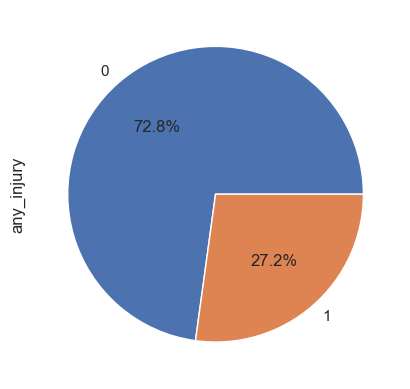

In [10]:
temp = train_csv['any_injury'].value_counts()
temp.plot(kind='pie', autopct='%1.1f%%')
plt.show()

spleen is the most unhealthy

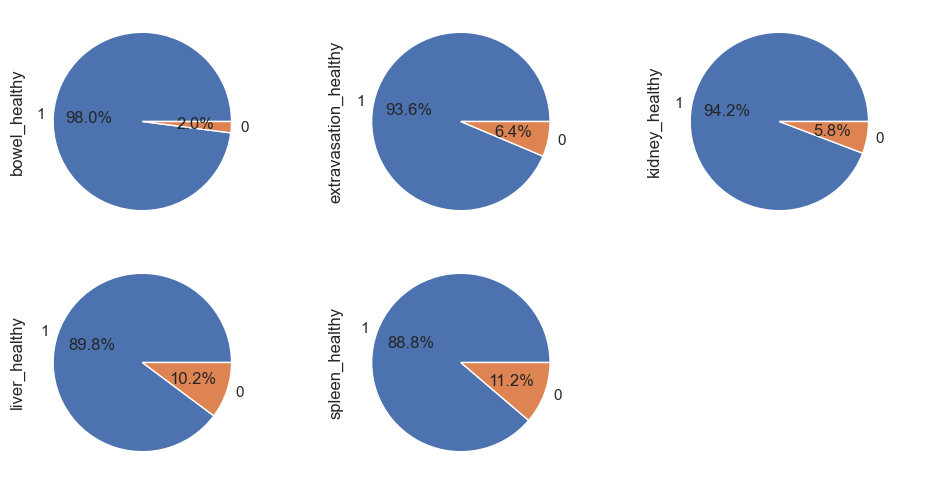

In [18]:
_, ax = plt.subplots(2, 3, figsize=(10, 5))
num_image = 0
for col in train_csv.columns:
    if col.endswith('_healthy'):
        row = num_image//3
        cols = num_image % 3
        temp = train_csv[col].value_counts()
        temp.plot(kind='pie', autopct='%1.1f%%',
                  ax=ax[row, cols])
        num_image += 1
ax[1, 2].axis('off')
plt.tight_layout()
plt.show()

# train_series_meta.csv

- summary: the "aortic_hu" value can be used as an indicator of the timing of the CT scan. In a multiphasic CT scan, a higher "aortic_hu" value suggests that the scan was taken during the late arterial phase, when the aorta is most enhanced with contrast due to the complete circulation of contrast-enhanced blood. This can be valuable information for accurately interpreting the scan and understanding the contrast dynamics within the body.

- the "aortic_hu" value is being used as a way to estimate the timing of the CT scan. This is because the density of the aorta can change depending on the phase of contrast enhancement during the scan.
- A multiphasic CT scan involves taking images of the same area of the body at different time points after the injection of a contrast dye. The contrast dye helps visualize blood vessels and other structures more clearly.
- During a multiphasic CT scan, different phases are captured based on the timing of the contrast injection. The "late arterial phase" refers to a specific point in time after the contrast injection when the contrast has fully flowed through the blood vessels, including the aorta. The aorta is most enhanced during this phase due to the high blood flow.

In [34]:
train_series_meta = pd.read_csv('train_series_meta.csv')
print(f'train_series_meta.shape: {train_series_meta.shape}')
train_series_meta.head()


train_series_meta.shape: (4711, 4)


,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
2,10005,18667,187.00,0
3,10007,47578,329.00,0
4,10026,29700,327.00,0


### Incompletely scanned organs
There are 313 training images with incompletely scanned organ, should we remove them?

Number of patients with complete organs: 0
Number of patients with incomplete organs: 4711


Text(0, 0.5, 'Count')

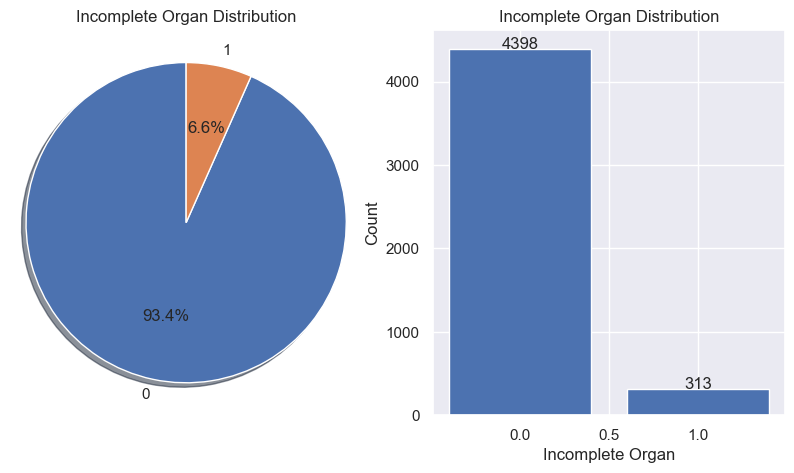

In [48]:
# print counts
incomplete_organ_count = train_series_meta['incomplete_organ'].value_counts()
# incomplete_organ_count = train_series_meta.groupby('incomplete_organ').count()['patient_id'].sort_values(ascending=False) # more flexible approach

print(f'Number of patients with complete organs: {train_series_meta.shape[0] - incomplete_organ_count.sum()}')
print(f'Number of patients with incomplete organs: {incomplete_organ_count.sum()}')

# create subplots, one is pie chart, the other is bar chart
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# pie chart
ax[0].pie(incomplete_organ_count, labels=incomplete_organ_count.index, autopct='%1.1f%%', shadow=True, startangle=90)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title('Incomplete Organ Distribution')

# bar chart
ax[1].bar(incomplete_organ_count.index, incomplete_organ_count)
# show the count on top of each bar
for i, v in enumerate(incomplete_organ_count):
    ax[1].text(i, v + 0.5, str(v), ha='center')

ax[1].set_title('Incomplete Organ Distribution')
ax[1].set_xlabel('Incomplete Organ')
ax[1].set_ylabel('Count')


## Aortic HU

Plot the histogram and boxplot of Aortic HU

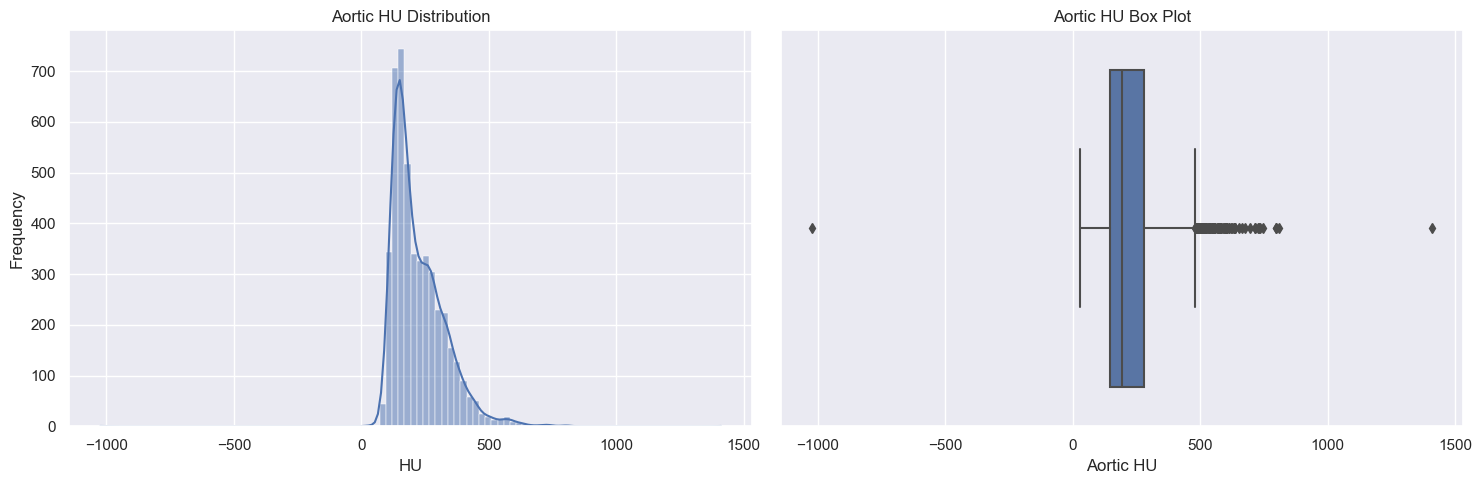

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Subplot 1: Histogram with KDE
sns.histplot(data=train_series_meta, x="aortic_hu", kde=True, bins=100, ax=axs[0])
axs[0].set_title('Aortic HU Distribution')
axs[0].set_xlabel('HU')
axs[0].set_ylabel('Frequency')

# Subplot 2: Box Plot
sns.boxplot(x='aortic_hu', data=train_series_meta, ax=axs[1])
axs[1].set_title('Aortic HU Box Plot')
axs[1].set_xlabel('Aortic HU')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

Remove the outliers

In [68]:
# Calculate z-scores for the 'aortic_hu' column
z_scores = np.abs((train_series_meta['aortic_hu'] - train_series_meta['aortic_hu'].mean()) / train_series_meta['aortic_hu'].std())

# Define a z-score threshold beyond which data p
# oints are considered outliers
z_score_threshold = 3.0

# Create a new DataFrame without outliers
train_series_meta_clean = train_series_meta[z_scores <= z_score_threshold]


Plot the histogram and boxplot of Aortic HU

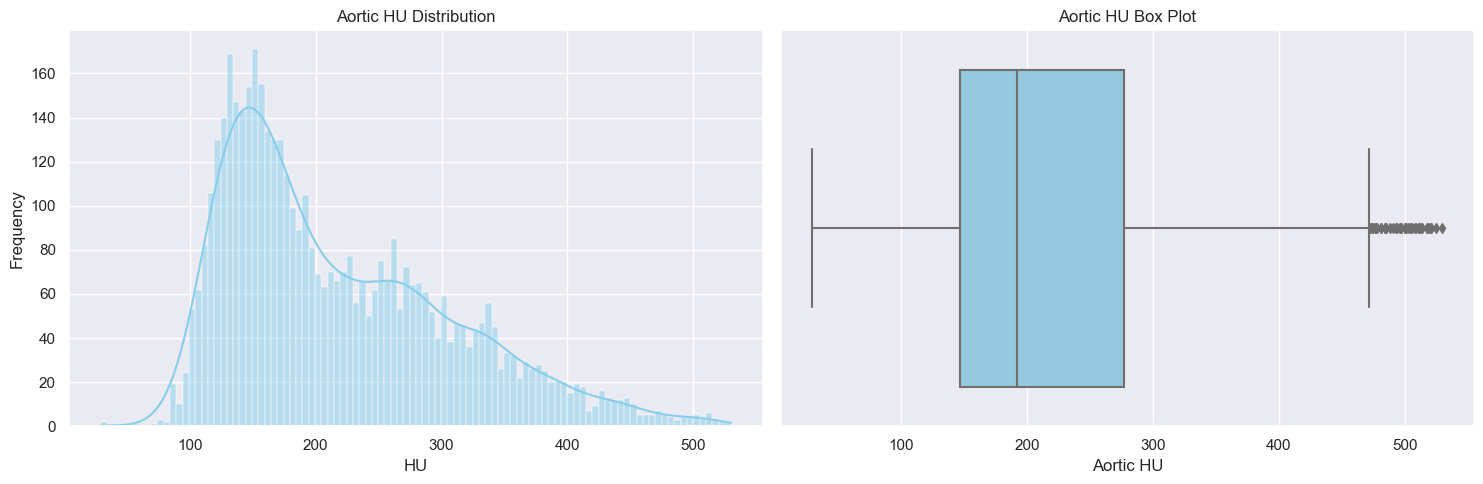

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Subplot 1: Histogram with KDE
sns.histplot(data=train_series_meta_clean, x="aortic_hu", kde=True, bins=100, ax=axs[0], color='skyblue')
axs[0].set_title('Aortic HU Distribution')
axs[0].set_xlabel('HU')
axs[0].set_ylabel('Frequency')

# Subplot 2: Box Plot
sns.boxplot(x='aortic_hu', data=train_series_meta_clean, ax=axs[1], color='skyblue')
axs[1].set_title('Aortic HU Box Plot')
axs[1].set_xlabel('Aortic HU')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

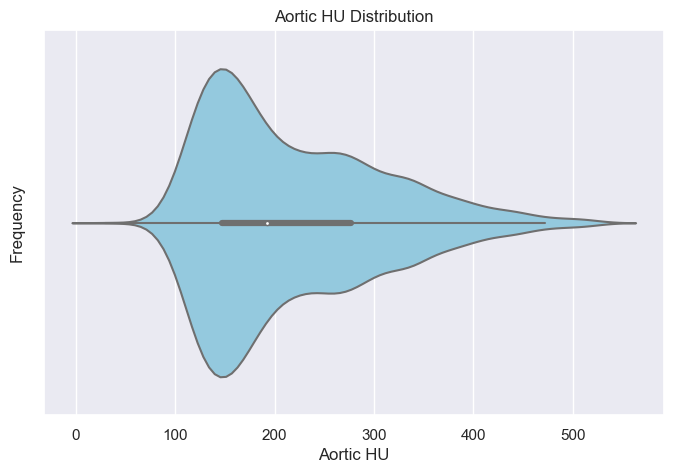

In [78]:
# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(8, 5))

# Create a violin plot
sns.violinplot(x='aortic_hu', data=train_series_meta_clean, ax=ax, color='skyblue')

# Set title and labels
ax.set_title('Aortic HU Distribution')
ax.set_xlabel('Aortic HU')
ax.set_ylabel('Frequency')

# Show the plot
plt.show()

# train_dicom_tags.parquet

In [83]:
# !pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 626.1 kB/s eta 0:00:0000:0100:140.8 MB 600.9 kB/s eta 0:07:51
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285397 sha256=b8a3a2acdfabea0467e4a085469d83de2a128c109603231560c54697312b2f02
  Stored in directory: /Users/zhiyiho/Library/Caches/pip/wheels/91/46/99/63d32bd67d58f84faf258c1acf6bb563a73ff0ee4a106c8da2
Successfully built pyspark


In [111]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

In [104]:
# spark.stop()
spark = SparkSession.builder.appName('Kaggle').getOrCreate()
train_dicom_tags = spark.read.parquet('train_dicom_tags.parquet')
train_dicom_tags.show(5)

+-------------+----------+-------+-----------+-------------+--------------------+-------+-----------------------+--------------------+--------------+-----+---------+---------------+-------------------------+-------------------+--------------+----------------+------------+----+--------------------+---------------+--------------------+------------+--------------+--------------------+------------+-----------+--------------------------+----------------------+-------------------------+-----------------------+--------------------------+-------------------+--------------------+-----------+
|BitsAllocated|BitsStored|Columns|ContentDate|  ContentTime| FrameOfReferenceUID|HighBit|ImageOrientationPatient|ImagePositionPatient|InstanceNumber|  KVP|PatientID|PatientPosition|PhotometricInterpretation|PixelRepresentation|  PixelSpacing|RescaleIntercept|RescaleSlope|Rows|      SOPInstanceUID|SamplesPerPixel|   SeriesInstanceUID|SeriesNumber|SliceThickness|    StudyInstanceUID|WindowCenter|WindowWidth|F

In [106]:
# print the rows and columns of the pyspark dataframe
print(f'Number of rows: {train_dicom_tags.count()}')
print(f'Number of columns: {len(train_dicom_tags.columns)}')

Number of rows: 1510373
Number of columns: 35


In [108]:
summary = train_dicom_tags.describe()
summary.show()

+-------+-------------+------------------+------------------+-------------------+------------------+--------------------+------------------+-----------------------+--------------------+------------------+------------------+-----------------+---------------+-------------------------+-------------------+--------------------+------------------+------------+-----------------+--------------------+---------------+--------------------+------------------+------------------+--------------------+------------+-----------+--------------------------+----------------------+-------------------------+-----------------------+--------------------------+-------------------+--------------------+-----------+
|summary|BitsAllocated|        BitsStored|           Columns|        ContentDate|       ContentTime| FrameOfReferenceUID|           HighBit|ImageOrientationPatient|ImagePositionPatient|    InstanceNumber|               KVP|        PatientID|PatientPosition|PhotometricInterpretation|PixelRepresentation|

| Information | Column Names |
| -------- | ------- |
| Image Data | BitsAllocated, BitsStored, PixelSpacing, RescaleIntercept, RescaleSlope |
| Patient Data | PatientID, StudyInstanceUID |
| Image Property | Rows, Columns, SOPInstanceUID |
| Unique identifiers | SOPInstanceUID, SeriesInstanceUID, and StudyInstanceUID |
| Imaging Settings | KVP, WindowCenter, and WindowWidth |
| DICOM standard | FileMetaInformationVersion, ImplementationClassUID, and TransferSyntaxUID |
| DICOM Image Location | path |

| Attribute                  | Description                                                                                                  |
|---------------------------|--------------------------------------------------------------------------------------------------------------|
| `BitsStored`               | Mean bits of data stored per pixel: ~14.25                                                                    |
| `Columns`                  | Mean number of columns: ~515.33                                                                              |
| `InstanceNumber`           | Mean instance number: ~325.35                                                                                |
| `KVP`                      | Mean X-ray tube voltage: ~116.26                                                                             |
| `PatientPosition`          | Position of the patient during imaging (e.g., FFS for feet-first supine)                                    |
| `PixelSpacing`             | Arrays of pixel spacing values for the images                                                                |
| `SOPInstanceUID`           | Unique identifier for instances in DICOM                                                                     |
| `SeriesInstanceUID`        | Unique identifier for series in DICOM                                                                        |
| `StudyInstanceUID`         | Unique identifier for studies in DICOM                                                                       |
| `WindowCenter`             | Windowing setting for images' visual representation                                                         |
| `WindowWidth`              | Windowing setting for images' visual representation                                                         |
| `path`                     | DICOM image files                                                       |
| `TransferSyntaxUID`        | Indicates the transfer syntax used for encoding the images                                                  |


| SeriesInstanceUID | 1.2.123.12345.1.2.3.49954.41479 |
| --- | --- |
| 0 | ?|
| 1 | ?|
| 2 | ?|
| 3 | ?|
| 4 | ?|
| 5 | ?|
| 6 | ?|
| 7 | patient_id |
| 8 | series_id |

In [116]:
# print all unique values in each column

# for col_name in train_dicom_tags.columns:
#     unique_values = train_dicom_tags.select((col_name)).distinct().collect()
#     unique_values = [str(row[0]) for row in unique_values]
#     print(col_name, unique_values)
#     print(f'{col_name}: \t\t {unique_values}')

print(f'RescaleType: \t\t {train_dicom_tags.select("RescaleType").distinct().collect()}')
    

RescaleType: 		 [Row(RescaleType='nan'), Row(RescaleType='Houndsfield Unit'), Row(RescaleType='HU')]


# Segmentation Folder

### Relationship between nii and dicom

| Aspect                    | NIfTI                                    | DICOM                                                    |
|---------------------------|------------------------------------------|----------------------------------------------------------|
| Purpose                   | Represent 3D/4D neuroimaging data         | Store and transmit medical images and info              |
| Format                    | `.nii` or `.nii.gz`                      | `.dcm` files in a folder structure                      |
| Data Structure            | 3D/4D grid with data array and header    | Image data, patient info, modality-specific data         |
| Header                    | Standardized header with metadata        | Extensive header with patient demographics and details  |
| Application               | Neuroscience research                    | Clinical imaging, device communication, PACS            |

- NIfTI and DICOM are related in that some medical imaging modalities can be converted to NIfTI format for research analysis.
- Conversion tools can convert DICOM data to NIfTI format while preserving spatial orientation and voxel dimensions.
- While DICOM is used for clinical applications and communication between devices, NIfTI is more common in neuroscience research.


In [6]:
import glob
import os 

from glob import glob

In [7]:
# data_dir = '/kaggle/input/rsna-2023-abdominal-trauma-detection'
data_dir = 'data'

segmentations_folder = os.path.join(data_dir, 'segmentations')


In [8]:
segmentations = glob(f'{data_dir}/segmentations/*')
len(segmentations)

1

In [9]:
seg_id_list = [int((id.split('/')[-1]).split('.')[0]) for id in segmentations]
print(f'** Number of ids: {len(seg_id_list)}')
print(f'** Example id: {seg_id_list[0]}')      

** Number of ids: 1
** Example id: 11748


In [10]:
# used with full dataset's present in the working directory

# df_train_w_seg = pd.merge(train_series_meta_clean, train_csv, how='inner', on='patient_id')

# # Convert seg_series_id to a set for faster membership checking
# seg_id_list_set = set(seg_id_list)

# # Create a 'has_seg' column indicating whether the series_id is in seg_series_id_set
# df_train_w_seg['has_seg'] = df_train_w_seg['series_id'].apply(lambda x: x in seg_id_list_set)

# # Group by 'any_injury' and 'has_seg', then count the occurrences of 'patient_id'
# df_train_w_seg.groupby(['any_injury', 'has_seg'])['patient_id'].count()

# # export to csv
# df_train_w_seg.to_csv('train_w_seg.csv', index=False)

In [11]:
# used with sample dataset's present in the working directory
# read the csv file
df_train_w_seg = pd.read_csv('data/train_w_seg.csv')
df_train_w_seg.head()

,patient_id,series_id,aortic_hu,incomplete_organ,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,has_seg
0,10004,21057,146.00,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,True
1,10004,51033,454.75,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,True
2,10005,18667,187.00,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,False
3,10007,47578,329.00,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,False
4,10026,29700,327.00,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,False


In [12]:
# !pip install nibabel

In [13]:
import nibabel as nib 

This nifti file has 53 slices, the number of slices is the value of the z-axis.

In [27]:
nifti_file = nib.load(os.path.join(segmentations_folder, '11748.nii'))
nifti_data = nifti_file.get_fdata()
print(f'** Shape of the mask: {nifti_data.shape}')
# print(f'** Nifti info: {nifti_file}')

** Shape of the mask: (512, 512, 53)


In [18]:
# # Choose a slice index (0 to n-1, where n is the number of slices)
# slice_index = nifti_data.shape[2] // 2  # You can change this to any valid slice index

# # Extract the slice from the NIfTI data
# slice_data = nifti_data[:, :, slice_index]

# # Display the slice using matplotlib
# plt.figure(figsize=(6, 6))
# plt.imshow(slice_data, cmap='gray')
# plt.title(f"NIfTI Slice at Index {slice_index}")
# plt.axis('off')
# plt.show()

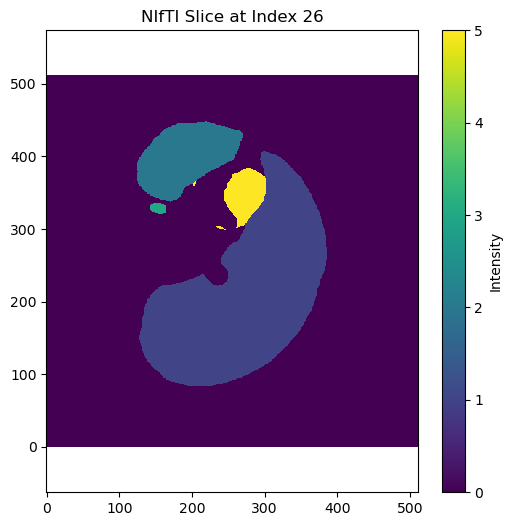

In [21]:
# Choose a slice index (0 to n-1, where n is the number of slices)
slice_index = nifti_data.shape[2] // 2  # You can change this to any valid slice index

# Extract the slice data from the NIfTI data
slice_data = nifti_data[:, :, slice_index]

# Create a meshgrid for the coordinates
x, y = np.arange(slice_data.shape[1]), np.arange(slice_data.shape[0])
X, Y = np.meshgrid(x, y)

# Create the pcolormesh plot
plt.figure(figsize=(6, 6))
plt.pcolormesh(X, Y, slice_data)
plt.colorbar(label='Intensity')
plt.title(f"NIfTI Slice at Index {slice_index}")
plt.axis('equal')
plt.show()

In [30]:
# Define the interactive plotting function
def plot_slice(slice_index):
    plt.figure(figsize=(6, 6))
    plt.imshow(nifti_data[:, :, slice_index])
    plt.title(f"NIfTI Slice at Index {slice_index}")
    plt.axis('off')
    plt.show()

In [31]:
from ipywidgets import interact, IntSlider

# Determine the number of slices
num_slices = nifti_data.shape[2]

# Create an interactive slider to slide through slices
interact(plot_slice, slice_index=IntSlider(min=0, max=num_slices - 1, step=1, value=num_slices // 2))


interactive(children=(IntSlider(value=26, description='slice_index', max=52), Output()), _dom_classes=('widget…

<function __main__.plot_slice(slice_index)>

In [22]:
# !pip install mayavi

In [23]:
# from mayavi import mlab

# # Create a volume rendering using Mayavi
# src = mlab.pipeline.scalar_field(nifti_data)
# vol = mlab.pipeline.volume(src)

# # Set visualization options
# mlab.view(azimuth=0, elevation=180, distance='auto')

# # Show the visualization
# mlab.show()

In [24]:
def create_3D_scans(folder, downsample_rate=1): 
    filenames = os.listdir(folder)
    filenames = [int(filename.split('.')[0]) for filename in filenames]
    filenames = sorted(filenames)
    filenames = [str(filename) + '.dcm' for filename in filenames]
        
    volume = []
    for filename in tqdm(filenames[::downsample_rate]):
        filepath = os.path.join(folder, filename)
        ds = dicom.dcmread(filepath)
        image = ds.pixel_array
        
        # find rescale params
        if ("RescaleIntercept" in ds) and ("RescaleSlope" in ds):
            intercept = float(ds.RescaleIntercept)
            slope = float(ds.RescaleSlope)
    
        # find clipping params
        center = int(ds.WindowCenter)
        width = int(ds.WindowWidth)
        low = center - width / 2
        high = center + width / 2    
        
        
        image = (image * slope) + intercept
        image = np.clip(image, low, high)

        image = (image / np.max(image) * 255).astype(np.int16)
        image = image[::downsample_rate, ::downsample_rate]
        volume.append( image )
    
    volume = np.stack(volume, axis=0)
    return volume


def create_3D_segmentations(filepath, downsample_rate=1):
    img = nib.load(filepath).get_fdata()
    img = np.transpose(img, [1, 0, 2])
    img = np.rot90(img, 1, (1,2))
    img = img[::-1,:,:]
    img = np.transpose(img, [1, 0, 2])
    img = img[::downsample_rate, ::downsample_rate, ::downsample_rate]
    return img


In [26]:
DS_RATE = 2
nifti_filepath = os.path.join(segmentations_folder, '11748.nii')
volume_seg = create_3D_segmentations(nifti_filepath, downsample_rate=DS_RATE)
print(f'3D segmentation file shape: {volume_seg.shape}')

3D segmentation file shape: (27, 256, 256)


# image_level_labels.csv

In [143]:
df_image_level_labels = pd.read_csv('data/image_level_labels.csv')
df_image_level_labels.head()

,patient_id,series_id,instance_number,injury_name
0,10004,21057,362,Active_Extravasation
1,10004,21057,363,Active_Extravasation
2,10004,21057,364,Active_Extravasation
3,10004,21057,365,Active_Extravasation
4,10004,21057,366,Active_Extravasation


# Training Folder

In [32]:
df = pd.read_csv('data/df_w_scan.csv')
df.head()

,patient_id,series_id,aortic_hu,incomplete_organ,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,has_seg,num_scans
0,10004,21057,146.00,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,True,1022
1,10004,51033,454.75,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,True,1044
2,10005,18667,187.00,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,False,103
3,10007,47578,329.00,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,False,116
4,10026,29700,327.00,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,False,515


In [38]:
# Calculate z-scores for the 'aortic_hu' column
z_scores = np.abs((df['aortic_hu'] - df['aortic_hu'].mean()) / df['aortic_hu'].std())

# Define a z-score threshold beyond which data p
# oints are considered outliers
z_score_threshold = 3.0

# Create a new DataFrame without outliers
df = df[z_scores <= z_score_threshold]

In [39]:
df['num_scans'].describe()

count    4645.000000
mean      318.303122
std       243.653462
min        41.000000
25%       152.000000
50%       207.000000
75%       481.000000
max      1727.000000
Name: num_scans, dtype: float64

In [40]:
# total number of CT scans available 
df['num_scans'].sum()

1478518

<Axes: xlabel='num_scans', ylabel='Count'>

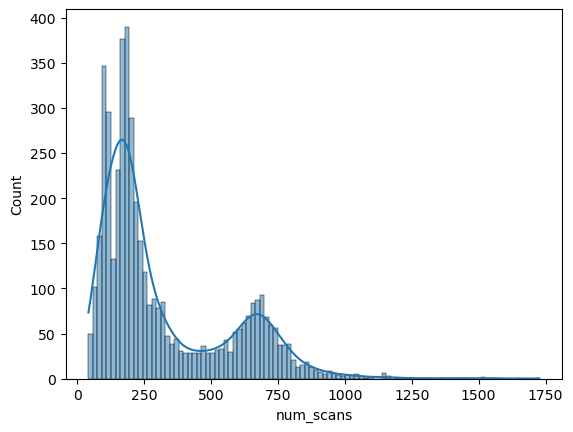

In [62]:
sns.histplot(data=df, x="num_scans", kde=True, bins=100)

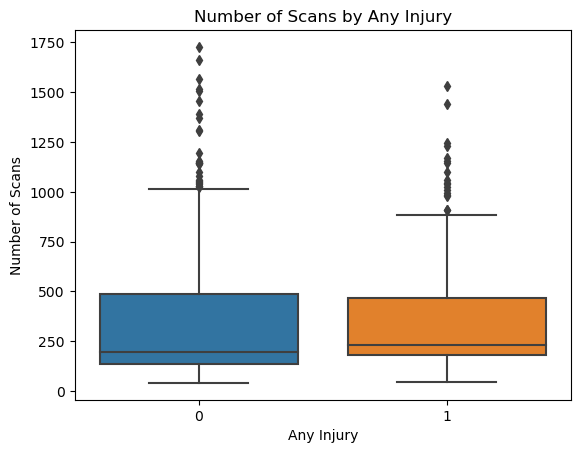

In [43]:
sns.boxplot(x='any_injury', y='num_scans', data=df)
plt.xlabel('Any Injury')
plt.ylabel('Number of Scans')
plt.title('Number of Scans by Any Injury')
plt.show()

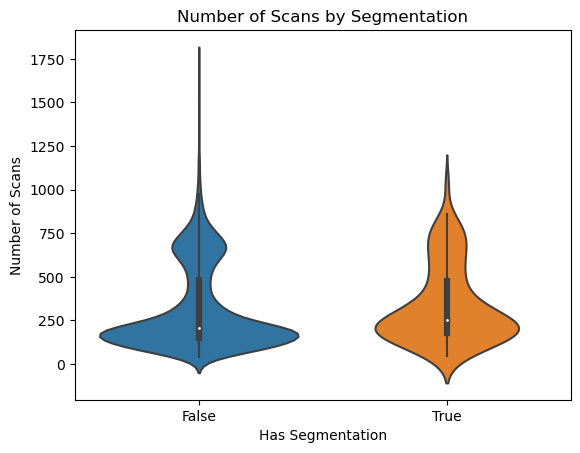

In [44]:
sns.violinplot(x='has_seg', y='num_scans', data=df)
plt.xlabel('Has Segmentation')
plt.ylabel('Number of Scans')
plt.title('Number of Scans by Segmentation')
plt.show()

In [46]:
grouped_mean = df.groupby('any_injury')['num_scans'].mean()
print(grouped_mean)

any_injury
0    312.994673
1    332.471564
Name: num_scans, dtype: float64


In [65]:
train_dir = os.path.join(data_dir, 'train_images')

In [79]:
def standardize_pixel_array(dicom_image):
    """
    Read the dicom file and preprocess appropriately.
    """
    pixel_array = dicom_image.pixel_array
    
    if dicom_image.PixelRepresentation == 1:
        bit_shift = dicom_image.BitsAllocated - dicom_image.BitsStored
        dtype = pixel_array.dtype 
        new_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
        pixel_array = pydicom.pixel_data_handlers.util.apply_modality_lut(new_array, dicom_image)
    
    if dicom_image.PhotometricInterpretation == "MONOCHROME1":
        pixel_array = 1 - pixel_array
    
    # transform to hounsfield units
    intercept = dicom_image.RescaleIntercept
    slope = dicom_image.RescaleSlope
    pixel_array = pixel_array * slope + intercept
    
    # windowing
    window_center = int(dicom_image.WindowCenter)
    window_width = int(dicom_image.WindowWidth)
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    pixel_array = pixel_array.copy()
    pixel_array[pixel_array < img_min] = img_min
    pixel_array[pixel_array > img_max] = img_max
    
    # normalization
    pixel_array = (pixel_array - pixel_array.min())/(pixel_array.max() - pixel_array.min())
    
    return pixel_array

def read_volume(paths):
    """
    Read the dicom slices and return a 3d volume.
    """
    images = [standardize_pixel_array(pydicom.dcmread(path)) for path in tqdm(paths)]
    return np.stack(images)

def create_3D_segmentations(filepath):
    """
    Read the .nii file and return 3d volume of segmentation.
    """
    img = nib.load(filepath).get_fdata()
    img = np.transpose(img, [1, 0, 2])
    img = np.rot90(img, 1, (1, 2))
    img = img[::-1, :, :]
    img = np.transpose(img, [1, 0, 2])
    return img


scans_path = os.path.join(train_dir, '10004/21057')
image_paths = [os.path.join(scans_path, f'{img}.dcm') for img in sorted([os.path.splitext(img)[0] for img in os.listdir(scans_path)], key=int)]




In [68]:
image_paths

['data/train_images/10004/21057/1000.dcm',
 'data/train_images/10004/21057/1001.dcm']

In [74]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.3 MB/s eta 0:00:0000:0100:01


In [80]:
import tqdm
import pydicom

from tqdm import tqdm

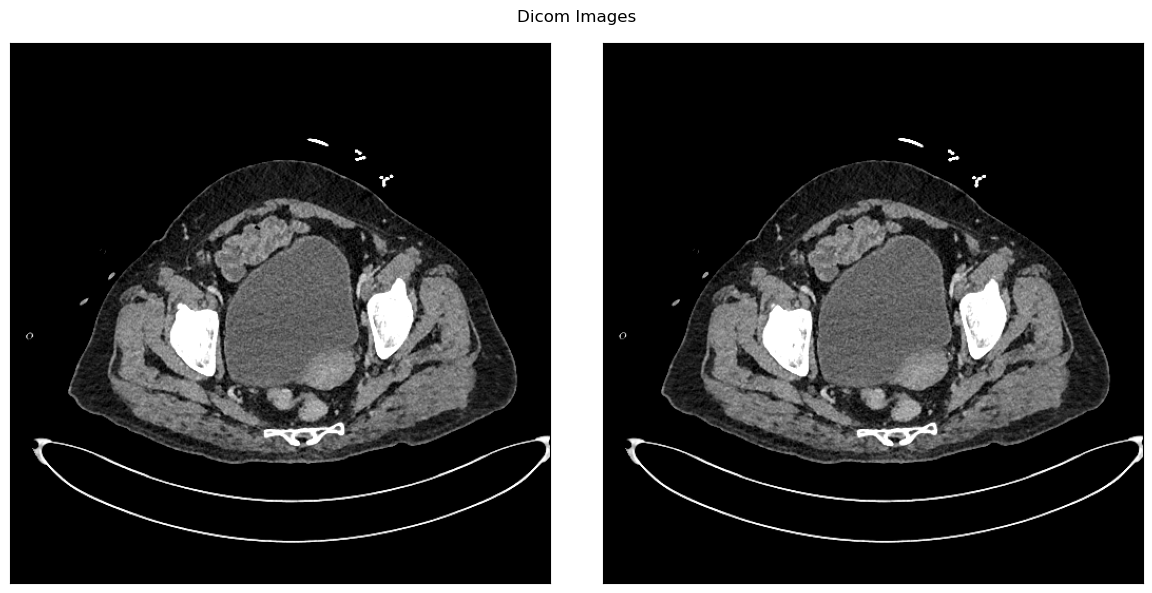

In [76]:
sample_scan = image_paths

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(2):
    image = pydicom.dcmread(image_paths[i])
    image = standardize_pixel_array(image)
    ax[i].imshow(image, cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])

plt.suptitle('Dicom Images')
plt.tight_layout()
plt.show()

In [81]:
nifti_path = os.path.join(segmentations_folder, '11748.nii')

sample_volume = read_volume(image_paths)
sample_seg = create_3D_segmentations(nifti_path)

100%|██████████| 2/2 [00:00<00:00, 60.88it/s]


In [82]:
# for the use with full dataset

# def plot_seg_map(sample_volume, seg=None):
    
#     """
#     Plot random slices in the 3d scan with axial, coronal and sagittal orientations.
#     """
    
#     coronal_index = sample_volume.shape[2]//2
#     axial_index = sample_volume.shape[2]//2
#     sagittal_index = sample_volume.shape[2]//2

#     # Get slices for different orientations
#     coronal_slice = sample_volume.transpose([1,0,2])[coronal_index, :, :]
#     coronal_seg = seg.transpose([1,0,2])
#     axial_slice = sample_volume[axial_index, :, :]
#     axial_seg = seg
#     sagittal_slice = sample_volume.transpose([2,0,1])[sagittal_index, :, :]
#     sagittal_seg = seg.transpose([2,0,1])
    
#     coronal_seg = np.where(coronal_seg[coronal_index, :, :], coronal_seg[coronal_index, :, :], np.nan)
#     axial_seg = np.where(axial_seg[axial_index, :, :], axial_seg[axial_index, :, :], np.nan)
#     sagittal_seg = np.where(sagittal_seg[sagittal_index, :, :], sagittal_seg[sagittal_index, :, :], np.nan)

#     # Create subplots for each orientation
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#     # Plot coronal orientation
#     axes[0].imshow(coronal_slice, cmap='viridis')
#     axes[0].imshow(coronal_seg, cmap='Set1')
#     axes[0].set_title('Coronal Slice')
#     axes[0].axis('off')

#     # Plot axial orientation
#     axes[1].imshow(axial_slice, cmap='viridis')
#     axes[1].imshow(axial_seg, cmap='Set1')
#     axes[1].set_title('Axial Slice')
#     axes[1].axis('off')

#     # Plot sagittal orientation
#     axes[2].imshow(sagittal_slice, cmap='viridis')
#     axes[2].imshow(sagittal_seg, cmap='Set1')
#     axes[2].set_title('Sagittal Slice')
#     axes[2].axis('off')

#     # Adjust layout
#     plt.tight_layout()

#     # Show the plot
#     plt.show()


# plot_seg_map(sample_volume, sample_seg)

IndexError: index 256 is out of bounds for axis 0 with size 2

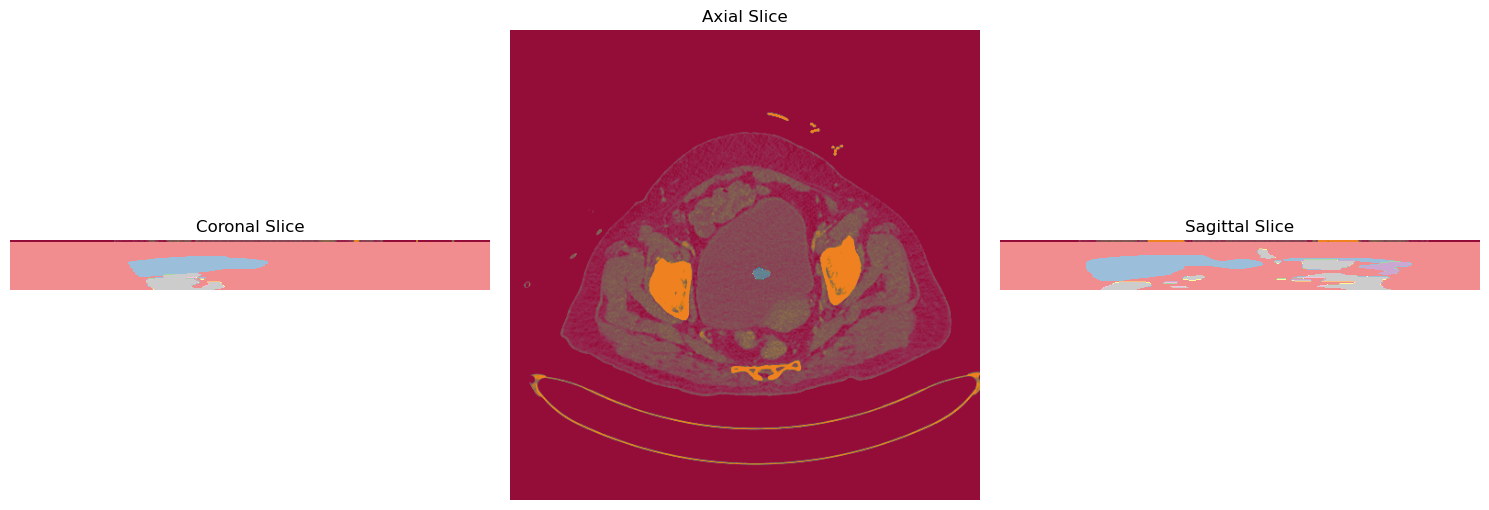

In [84]:
def plot_seg_map(sample_volume, seg=None):
    """
    Plot random slices in the 3d scan with axial, coronal and sagittal orientations.
    """
    coronal_index = sample_volume.shape[2] // 2
    axial_index = sample_volume.shape[0] // 2
    sagittal_index = sample_volume.shape[1] // 2

    # Get slices for different orientations
    coronal_slice = sample_volume[:, :, coronal_index]
    coronal_seg = seg[:, :, coronal_index] if seg is not None else None
    axial_slice = sample_volume[axial_index, :, :]
    axial_seg = seg[axial_index, :, :] if seg is not None else None
    sagittal_slice = sample_volume[:, sagittal_index, :]
    sagittal_seg = seg[:, sagittal_index, :] if seg is not None else None

    # Create subplots for each orientation
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot coronal orientation
    axes[0].imshow(coronal_slice, cmap='viridis')
    if coronal_seg is not None:
        axes[0].imshow(coronal_seg, cmap='Set1', alpha=0.5)
    axes[0].set_title('Coronal Slice')
    axes[0].axis('off')

    # Plot axial orientation
    axes[1].imshow(axial_slice, cmap='viridis')
    if axial_seg is not None:
        axes[1].imshow(axial_seg, cmap='Set1', alpha=0.5)
    axes[1].set_title('Axial Slice')
    axes[1].axis('off')

    # Plot sagittal orientation
    axes[2].imshow(sagittal_slice, cmap='viridis')
    if sagittal_seg is not None:
        axes[2].imshow(sagittal_seg, cmap='Set1', alpha=0.5)
    axes[2].set_title('Sagittal Slice')
    axes[2].axis('off')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_seg_map(sample_volume, sample_seg)
